# Build Retrieval Augmented Generation Intelligent Query Agent - Code Walkthrough
In the following use case example, we’ll showcase how Cohere’s Generate, Embed, and Reranker model can search and
query across a repository of financial reports and articles.

### Step 0: Enable Model Access Through Amazon Bedrock and Sagemaker

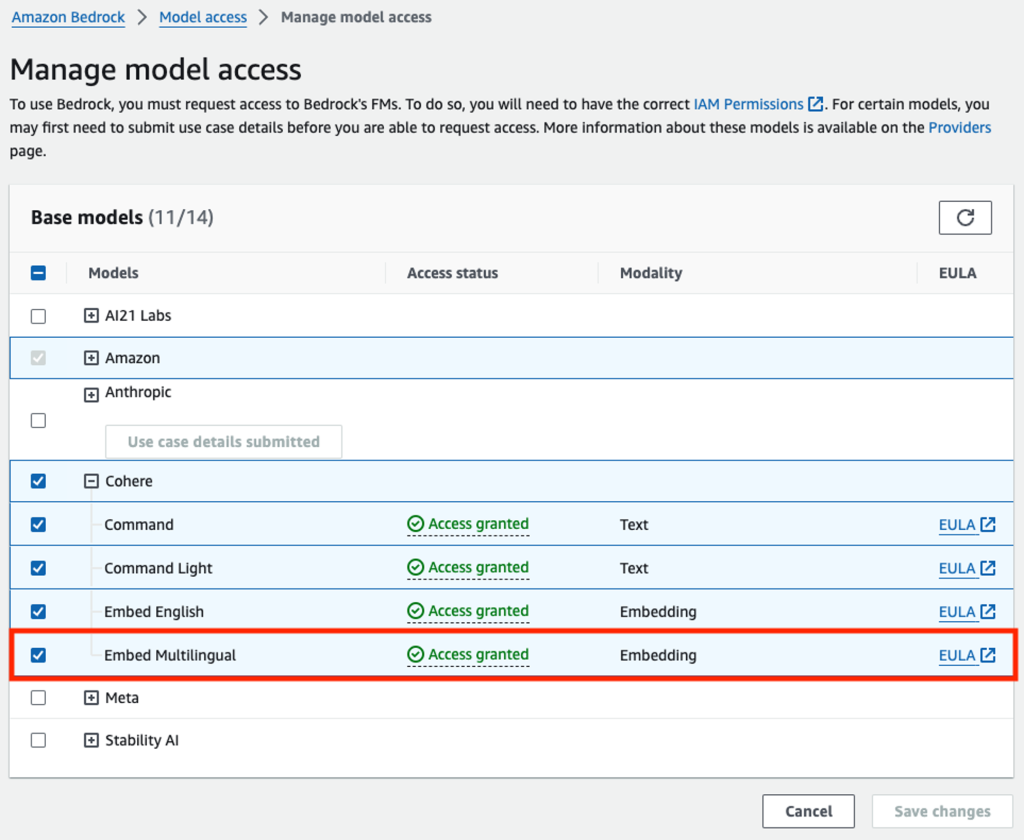

Enable Model access through the [Amazon Console](https://console.aws.amazon.com/bedrock) following the instructions in the [Amazon Bedrock Documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access.html) console.

For this walkthrough you will need to request access to the Cohere Embed Multilingual model.

###  Subscribe to the model package in SageMaker


Rerank is available in SageMaker.


To subscribe to the model package:
1. Open the model package listing page [cohere-rerank-multilingual](https://aws.amazon.com/marketplace/pp/prodview-pf7d2umihcseq)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

### Step 1: Install Packages, Import Modules, and Create Model Endpoints

In [3]:
!pip install --upgrade cohere-aws cohere hnswlib pandas numpy markdown boto3 -q
# If you upgrade the package, you need to restart the kernel

### Step 2: Import, transform and chunk data set

In [4]:
import pandas as pd
import cohere_aws
import cohere
import hnswlib
import warnings
import boto3
import json
import markdown as md
from IPython.display import HTML
warnings.filterwarnings('ignore')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [5]:
# Get secret key from AWS Secrets Manager for Cohere Chat API
from botocore.exceptions import ClientError


def get_secret():

    secret_name = "Cohere_API_Key"
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    return get_secret_value_response['SecretString']

In [6]:
API_Key = json.loads(get_secret())
cohere_api_key = API_Key.get('Cohere_API_Key')

In [7]:
#Bedrock Endpoint used for Command, Embed
co_bed = cohere_aws.Client(mode=cohere_aws.Mode.BEDROCK, region_name="us-east-1")

#connect to sagemaker endpoint for reranker
region = "us-east-1"
co_rk = cohere_aws.Client(region_name=region)
#co_rk.create_endpoint(arn=model_package_arn, endpoint_name="cohere-rerank-multilingual", instance_type="ml.g4dn.xlarge", n_instances=1, role="arn:aws:iam::907033419796:role/sage_maker_notebook")

#connect to SageMaker endpoint for embed. Rerank is not available on Bedrock yet.
co_rk.connect_to_endpoint(endpoint_name="cohere-rerank-v3")

#connect to Bedrock endpoint for embed
co_em = cohere_aws.Client(mode=cohere_aws.Mode.BEDROCK)
model_id = "cohere.embed-english-v3"

region = boto3.Session().region_name

# Create a client for Chat_Stream
co_chat = cohere.Client(cohere_api_key)

In [8]:
s3 = boto3.client('s3')

def iterate_bucket_items(bucket):
    text = []
    names = []


    result = s3.list_objects(Bucket = bucket)
    for o in result.get('Contents'):
        data = s3.get_object(Bucket=bucket, Key=o.get('Key'))
        text.append(str(data['Body'].read()))
        names.append(str(o.get('Key'))),
    return text, names


bucket = "finserv-analyst-reports"
text, names = iterate_bucket_items(bucket)
df = pd.DataFrame({'text': text, 'name': names})
# Read the data
print(f'Total number of financial reports imported : {len(df)}')    

Total number of financial reports imported : 543


In [9]:
#split each article into chunks of n words or less return a list of tuples (chunk, original text) with an overlap of m words
def split_text(text,name, n, m=0):
    words = text.split()
    chunks = []
    for i in range(0, len(words), n-m):
        chunk = ' '.join(words[i:i+n])
        chunks.append((chunk, text, name))
    return chunks

df = df.drop_duplicates()
chunks = []
for i, row in df.iterrows():
    chunks.extend(split_text(row['text'], row['name'],150, 15))
df = pd.DataFrame(chunks, columns=['chunk', 'original_text', 'name'])
print(f'The reports were split into a total number of {len(df)} chunks')

The reports were split into a total number of 5350 chunks


### Step 3: Bulk Embed and Index Documents

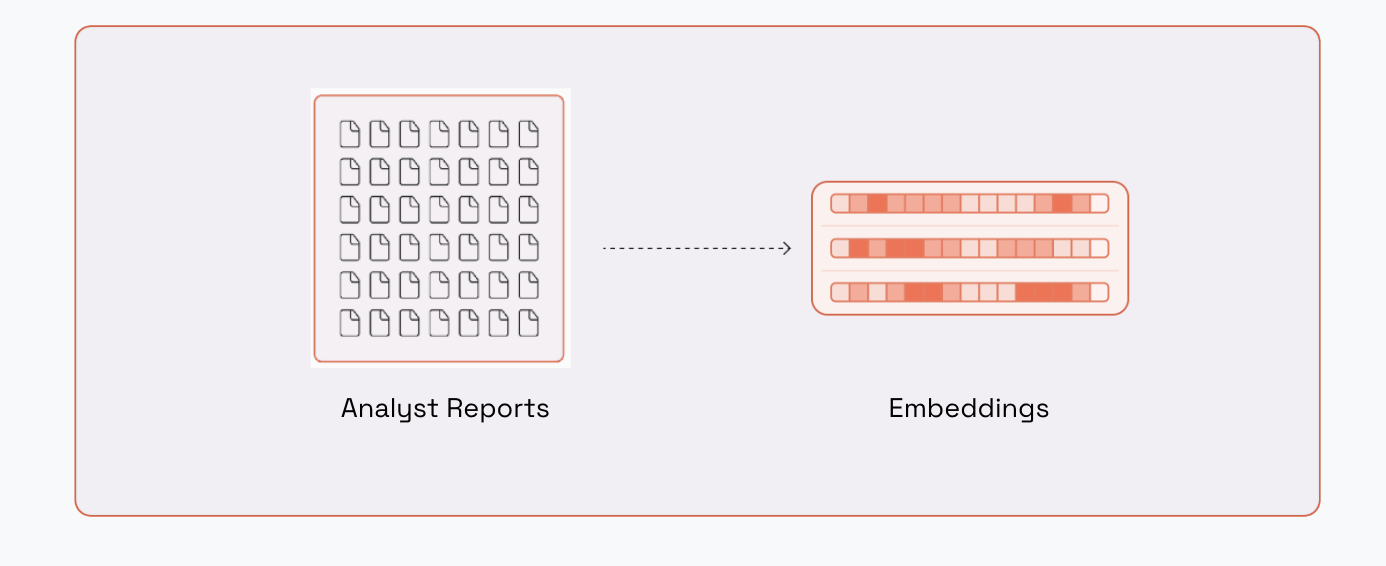

In [10]:
# Embed documents
# def embed_docs():
doc_embs =[]
docs = df['chunk'].to_list()
input_type = 'search_document'

batch_size=96

from tqdm import tqdm
for i in tqdm(range(0, len(docs), batch_size)):

    batch_docs = docs[i:i+batch_size]
    response = co_em.embed(
        texts=batch_docs, 
        input_type=input_type, 
        model_id=model_id
    )
    doc_embs.extend(response.embeddings)

# doc_embs, docs = embed_docs()
print(f'Total Documents chunked : {len(docs)}')    
        
#     return doc_embs, docs

100%|██████████| 56/56 [00:55<00:00,  1.01it/s]

Total Documents chunked : 5350


In [11]:
## Create a search index with hnswlib, a library for fast approximate nearest neighbor search

index = hnswlib.Index(space='ip', dim=1024) # Cohere embed outputs embeddings with 1024 dimensions
index.init_index(max_elements=len(doc_embs), ef_construction=1024, M=64) # For more info: https://github.com/nmslib/hnswlib#api-description
index.add_items(doc_embs, list(range(len(doc_embs))))

### Step 4: Query the Datastore

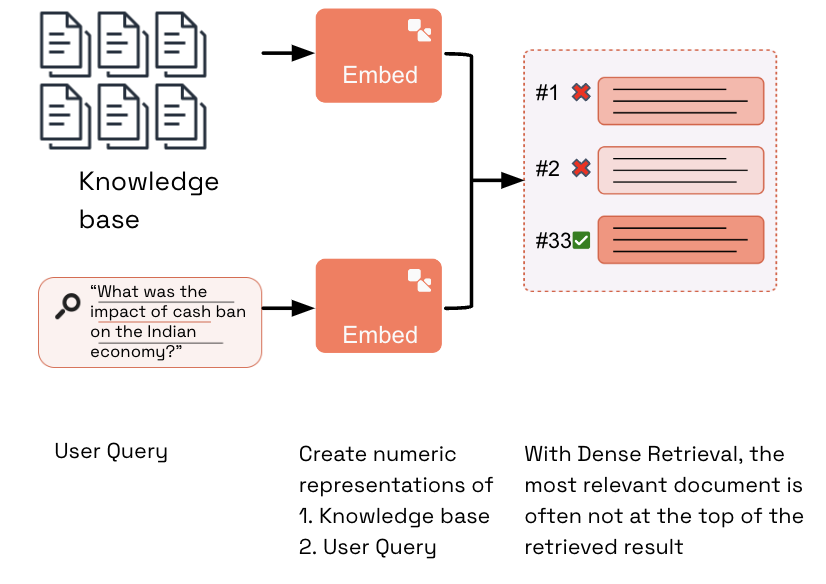

In [12]:
# Retrieval of 10 closest docs to query
def retrieval(query, df, k):
    # Embed query and retrieve results
    docs = df['chunk'].to_list()
    co = cohere_aws.Client(mode=cohere_aws.Mode.BEDROCK)
    query_emb = co.embed(
        texts=[query],
        input_type='search_query', 
        model_id=model_id
    )
    query_emb = query_emb.embeddings[0]
    doc_ids = index.knn_query(query_emb, k=k)[0][0] # we will retrieve k closest neighbors

    retrieved_docs, retrieved_chunks, names = [], [],[]
    
    for doc_id in doc_ids:
        # Append results
        retrieved_chunks.append(docs[doc_id])
        retrieved_docs.append((df['original_text'].iloc[doc_id]))
        names.append(df['name'].iloc[doc_id])
    
    return doc_ids, retrieved_chunks, retrieved_docs, names         

In [13]:
# Dense retrieval does return the search results. However the most relevant results may not always be at 
# the top of the retrieved dataset

query = 'Impact of cash ban on the Indian economy' 
ret_doc_ids, retrieved_chunks, retrieved_docs, names = retrieval(query, df, 10)


#Print doc ids and the document chunks
for doc_id in ret_doc_ids:
    # Append results
    print(doc_id)
    print(docs[doc_id])

2516
delicate balance between providing enough liquidity and maintaining financial stability.\n\nIndia's central bank has also cut its key policy rate, in a bid to stimulate the economy. This could potentially boost economic growth and assuage some of the pain caused by demonetization. The rate cut is expected to encourage banks to reduce lending rates, which could stimulate investments and ease some of the slowdown's pressures. But its impact will be felt over time, and the full effects might not be seen until the next quarter.\n\nThe stock markets have reacted negatively to the demonetization announcement, with the benchmark Sensex falling over 6% in the week following the move. The markets have been volatile ever since, wiping out over $60 billion in investor wealth. Sectors that rely heavily on cash transactions have been the worst hit, with real estate, auto, and consumer durables stocks leading the decline. However, some analysts also see this
2514
Goods and Services Tax (GST), w

### Step 5: Improve Results with Cohere Rerank

The following query is not returning the most relevant result at the top, here is where Rerank will help.

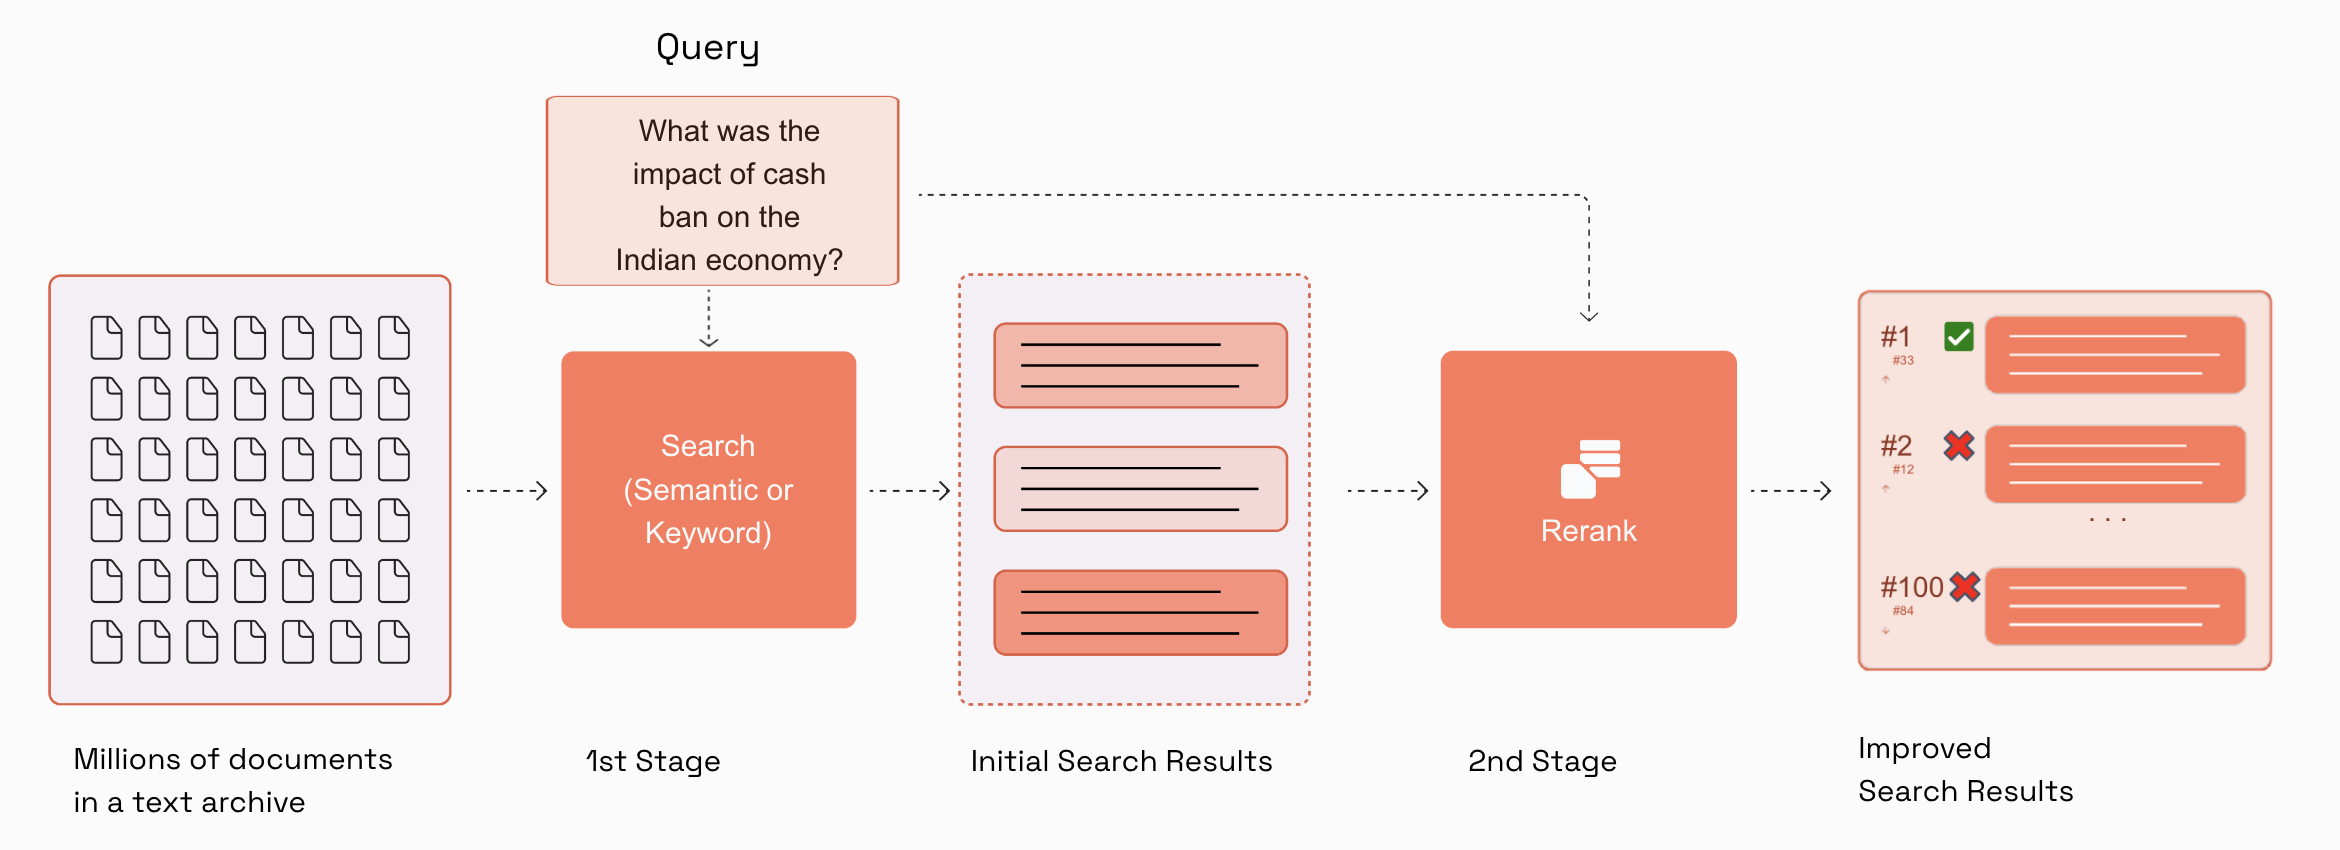

In [14]:
def rerank(query, chat):

    # Retrieve top 10 results using dense retrieval    
    doc_ids, retrieved_chunks, retrieved_docs, names = retrieval(query, df, 10)

    rerank_results = co_rk.rerank(query=query, 
                                    documents=retrieved_chunks, 
                                    top_n=5)

    re_ranked_docs = {}
    docs_retrieved = []
    
    for idx, r in enumerate(rerank_results):
        re_ranked_docs = r.document['text']
        docs_retrieved.append(
                    {
                        "text": r.document['text'],
                    }
                )
# Print outputs only when not in chat mode 
        if not chat:
            print(f"Document Rank: {idx + 1}, Document ID :{doc_ids[r.index]}, Document Index: {r.index}")
            print(re_ranked_docs)  
            print(f"Relevance Score: {r.relevance_score:.2f}")
            print("\n")
        
#     return docs_retrieved
    return docs_retrieved

In [15]:
rerank(query, False)

Document Rank: 1, Document ID :2512, Document Index: 5
b"On November 8, in a surprise move, India's Prime Minister Narendra Modi announced the demonetization of high-value currency. The decision was taken to combat corruption, and it has had a huge impact on the economy, business, and markets. This move has resulted in the invalidation of 86% of the country's currency, leading to a massive liquidity crunch. People have been standing in long queues outside banks and ATMs, hoping to exchange or deposit their now-worthless high-value bank notes. The government has also introduced new higher-value currency notes to ease the pain, but the situation on the ground remains challenging.\n\nThe demonetization drive aims to reshape the economy and boost the country's GDP in the long run, but it will also certainly impact India's short-term economic growth. The measure is expected to impact several sectors, with some analysts arguing that the move's timing, execution, and planning leave a lot to b

[{'text': 'b"On November 8, in a surprise move, India\'s Prime Minister Narendra Modi announced the demonetization of high-value currency. The decision was taken to combat corruption, and it has had a huge impact on the economy, business, and markets. This move has resulted in the invalidation of 86% of the country\'s currency, leading to a massive liquidity crunch. People have been standing in long queues outside banks and ATMs, hoping to exchange or deposit their now-worthless high-value bank notes. The government has also introduced new higher-value currency notes to ease the pain, but the situation on the ground remains challenging.\\n\\nThe demonetization drive aims to reshape the economy and boost the country\'s GDP in the long run, but it will also certainly impact India\'s short-term economic growth. The measure is expected to impact several sectors, with some analysts arguing that the move\'s timing, execution, and planning leave a lot to be desired.\\n\\nModi\'s'},
 {'text': 

### Step 6: Bringing it all together - Using Cohere Command, Embed and Rerank
Generate query responses from the reranked document set; Guide the model to produce responses based on a preamble; Add citations for results produced; 

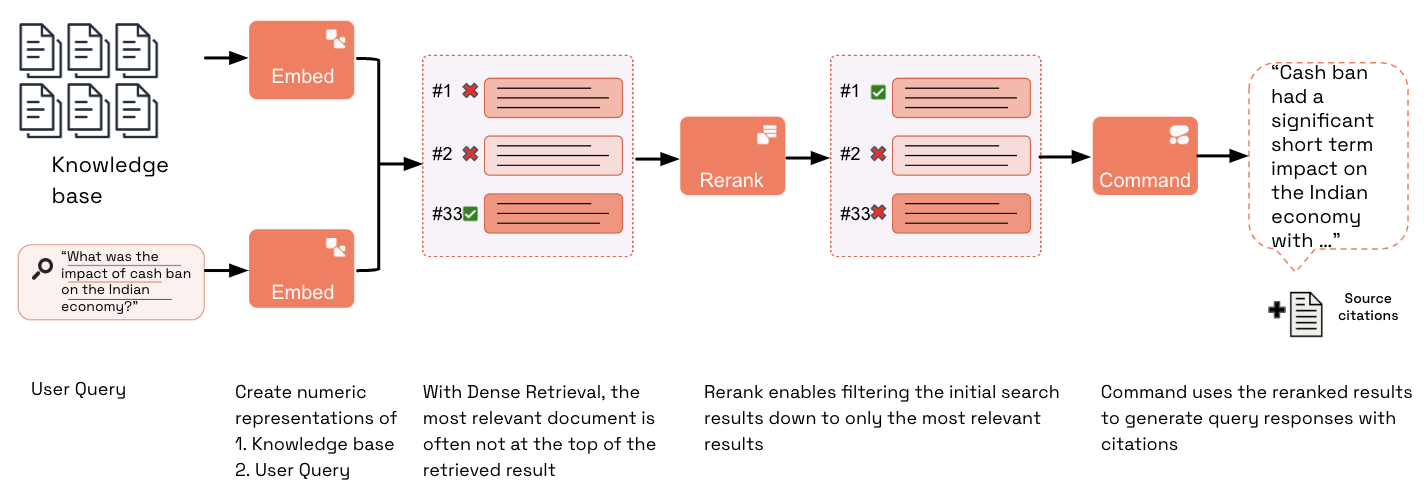

In [16]:
preamble = "You are a helpful digital assistant. \nPlease answer questions only based on the contents of the documents. \nIf the documents do not contain the answers to my question please say I dont know."
print(preamble)

You are a helpful digital assistant. 
Please answer questions only based on the contents of the documents. 
If the documents do not contain the answers to my question please say I dont know.


In [17]:
class Chatbot:
    
    
    
    def run(self):
        """
        Runs the chatbot application.

        """
        while True:
            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
              print("Ending chat.")
              break
            # Generate search queries (if any)
            response = co_chat.chat(message=message,
                               model="command-r",
                               search_queries_only=True)

            # If there are search queries, retrieve document chunks and respond
            if response.search_queries:
                print("Retrieving information...", end="")

                # Retrieve document chunks for each query
                reranked_docs = []
                reranked_docs = rerank(message, True)

                # Use document chunks to respond
                response = co_chat.chat_stream(
                    message=message,
                    model="command-r",
                    preamble = preamble,
                    documents=reranked_docs,
                )

            # If there is no search query, directly respond
            else:
                response = co_chat.chat_stream(
                    message=message,
                    model="command-r",
                )

            # Print the chatbot response, citations, and documents
            citations = []
            cited_documents = []

            print("\nRESPONSE:")

            # Display response
            for event in response:
                if event.event_type == "text-generation":
                    print(event.text, end="")
                elif event.event_type == "citation-generation":
                    citations.extend(event.citations)
                elif event.event_type == "search-results":
                    cited_documents = event.documents


            # Display citations and source documents
            if citations:
                print("\n\nCITATIONS:")
                for citation in citations:
                  print(citation)

                print("\nDOCUMENTS:")
                for document in cited_documents:
                  print(document)
                  print(f"\n{'-'*100}\n") 

In [18]:
# Create an instance of the Chatbot class
chatbot = Chatbot()

# Run the chatbot
chatbot.run()

User: Impact of cash ban on the Indian economy
Retrieving information...
RESPONSE:
India's demonetisation of high-value currency has had a huge impact on its economy. The move aims to reshape the economy in the long term and boost the country's GDP, but it will also significantly impact short-term growth. 

The invalidation of 86% of the country's currency has led to a liquidity crunch, and sectors that rely heavily on cash transactions have been the most affected. Economic activity has slowed, with people focusing on exchanging or depositing old notes. The real estate and jewellery sectors have been particularly hard hit. 

Markets have also reacted negatively, with the benchmark Sensex falling over 6% in the week following the announcement. Meanwhile, the government's ambitious move has raised concerns about its ability to manage the economy, with some analysts forecasting a 1-2% decline in GDP for the current fiscal year.

However, the long-term benefits are expected to outweigh the

### Step 7: Clean-up
Delete the endpoints

In [20]:
co_rk.delete_endpoint()
co_rk.close()